# Project 1: Mining information from Text Data 
<hr>

## Task 1: Finding Similar Items

Randomly select 1000 abstracts from the whole dataset. Find the similar items using pairwise Jaccard similarities, MinHash and LSH (vectorized versions) .

1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

3. For MinHashing using 100 hashing functions and s = 0.1 and 0.2, find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each s. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

 
 

<hr>

#### 1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

0. Import libraries

In [33]:
from urllib.request import urlopen
from io import BytesIO
from time import time

import pandas as pd
import gzip
import re
import binascii
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

1. Download the data files

In [99]:
url  = 'https://aclanthology.org/anthology+abstracts.bib.gz'   # url where the file is stored
filename = 'anthology+abstracts.bib'                           # bib filename
folder   = 'data'                                              # folder name
minimum = 200                                                  # minimum number of words in the abtract to be considered 

# Create the path to store the files
os.makedirs(folder, exist_ok=True)

file = folder + '/' + filename

# Download the file if it doesn't exist locally
if(not os.path.exists(file)):
  print("Downloading " + url + " to /" + folder + "..." )
  with gzip.open(BytesIO(urlopen(url).read()), 'rb') as fb:
    with open(file, 'wb') as f:
        f.write(fb.read())
else:
  print("File " + filename + " already available in folder /" + folder)        


File anthology+abstracts.bib already available in folder /data


2. Load data and make some preprocessing

In [53]:
# Read and process data
abstracts = []
titles = []
ids = []

with open(file, 'r',errors='ignore') as f:
    for line in f:    
      if '@proceedings{' in line:                                 # key found
        line = re.sub('@proceedings{', '', line)                  # remove 
        line = re.sub(',', '', line)                              # remove 
        line = re.sub('\n', '', line)                             # remove some other characters  
        id = line  
      if '@inproceedings{' in line:                               # key found
        line = re.sub('@inproceedings{', '', line)                # remove 
        line = re.sub(',', '', line)                              # remove 
        line = re.sub('\n', '', line)                             # remove some other characters  
        id = line            
      if ' title = "' in line:                                    # title found
        line = re.sub(' title = "', '', line)                     # remove "title ="
        title = line
      if 'abstract = "' in line:                                  # abstract found
        if len(re.findall('[a-zA-Z]', line)) > .2*len(line):      # ignore non latin
          if len(line) > minimum:                                 # ignore abstracts with less than minimum words (200)
            line = re.sub(' +', ' ', line)                        # remove double spaces
            line = re.sub(' abstract = ', '', line)               # remove "abstract =" 
            line = re.sub('"|\n|,', '', line)                     # remove some other characters  
            line = line.lower()                                   # transform to lower letters             
            abstracts.append(line)
            titles.append(title)
            ids.append(id)

print('Number of abstracts:', len(abstracts))
print('Number of titles:', len(titles))
print('Number of ids:', len(ids))
print('\nAbstract:', abstracts[0])
print('\nTitle:', titles[0])
print('ID:', ids[0])

Number of abstracts: 30104
Number of titles: 30104
Number of ids: 30104

Abstract: offensive language detection (old) has received increasing attention due to its societal impact. recent work shows that bidirectional transformer based methods obtain impressive performance on old. however such methods usually rely on large-scale well-labeled old datasets for model training. to address the issue of data/label scarcity in old in this paper we propose a simple yet effective domain adaptation approach to train bidirectional transformers. our approach introduces domain adaptation (da) training procedures to albert such that it can effectively exploit auxiliary data from source domains to improve the old performance in a target domain. experimental results on benchmark datasets show that our approach albert (da) obtains the state-of-the-art performance in most cases. particularly our approach significantly benefits underrepresented and under-performing classes with a significant improvement o

In [54]:
# Creating a dataframe with abstract, title and id
data_tuples = list(zip(ids, titles, abstracts))
data = pd.DataFrame(data_tuples, columns=['ID', 'title', 'abstract'])

In [55]:
data

,ID,title,abstract
0,singh-li-2021-exploiting,Exploiting Auxiliary Data for Offensive Lan...,offensive language detection (old) has receive...
1,hahn-etal-2021-modeling,Modeling Profanity and Hate Speech in Socia...,hate speech and profanity detection suffer fro...
2,caselli-etal-2021-hatebert,{H}ate{BERT}: Retraining {BERT} for Abusive...,we introduce hatebert a re-trained bert model ...
3,kirk-etal-2021-memes,Memes in the Wild: Assessing the Generaliza...,hateful memes pose a unique challenge for curr...
4,kivlichan-etal-2021-measuring,Measuring and Improving Model-Moderator Col...,content moderation is often performed by a col...
...,...,...,...
30099,raphael-1963-computer,A computer representation for semantic info...,this paper deals with the problem of represent...
30100,tabory-1963-specifications,Specifications for generative grammars used...,it becomes more and more evident that successf...
30101,tosh-1963-collecting,Collecting linguistic data for the grammar ...,establishing the grammatical description of a ...
30102,wahlgren-1963-derivational,Derivational suffixes in {R}ussian general ...,a grammar based upon a conventional morphemic ...


3. Randomly select 1000 abstracts and save them to a file

In [100]:
# Randomly select 1000 rows
data = data.sample(n=1000, random_state=1)
# Reset index
data = data.reset_index(drop=True)
# Get abstracts
abstracts = data['abstract'].tolist()

# save abstracts to a file for other tasks
os.makedirs(folder, exist_ok=True)  
data.to_csv('./data/abstracts.csv')

4. Define main functions

In [86]:
" Returns the k hasshed shingles of a"
def get_shingles(a, k):
    L = len(a)
    shingles = set()                                   # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):                              
        shingle = a[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8'))  # hash the shingle to a 32-bit integer
        shingles.add(crc)    
    return shingles

In [87]:
" Returns the jaccard similarity score of two sets (x y) "
def jaccard_similarity_score(x, y):
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [88]:
" Minhashing "
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [89]:
" Locality Sensitive Hashing "
def LSH(signatures, bands, rows, Ab, Bb, nextPrime, maxShingleID):
    numItems = signatures.shape[1]
    signBands = np.array_split(signatures, bands, axis=0)
    candidates = set()
    for nb in range(bands):
        hashTable = {}
        for ni in range(numItems):
            item = signBands[nb][:,ni]
            hash = (np.dot(Ab[nb,:], item) + Bb[nb]) % nextPrime % maxShingleID
            if hash not in hashTable:
                hashTable[hash] = [ni]
            else:
                hashTable[hash].append(ni)
        for _,items in hashTable.items():
            if len(items) > 1:
                L = len(items)
                for i in range(L-1):
                    for j in range(i+1, L):
                        cand = [items[i], items[j]]
                        np.sort(cand)
                        candidates.add(tuple(cand))
    return candidates

In [90]:
" Plot results "
def plot_results(title, times, num_of_similar_items, objects):
    plt.rcParams["figure.figsize"] = (19,6)

    plt.subplot(1,2,1)
    objects = objects
    y_pos = np.arange(len(objects))
    metric = times
    plt.barh(y_pos, metric, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.title(title +' (time)')

    plt.subplot(1,2,2)
    y_pos = np.arange(len(objects))
    metric = num_of_similar_items
    plt.yticks(y_pos, objects)
    plt.barh(y_pos, metric, align='center', alpha=0.5)    
    plt.title(title + ' (items)')

    plt.show()

4. Jaccard Similarity: **(CAUTION: This process takes long execution time!!)**

In [93]:
# Get candidate pairs using naive approach

similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for s in similarity_threshold:
    for k in k_shingles:
        candidates = []
        t = time()
        for pair in itertools.combinations(abstracts,2):
            js = jaccard_similarity_score(get_shingles(pair[0], k),get_shingles(pair[1], k))    
            if js > s:
                candidates.append(pair)
        t1 = time()-t
        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        num_of_similar_items.append(len(candidates))
        times.append(t1)
        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 496368
Took 498.65155816078186 seconds



KeyboardInterrupt: 

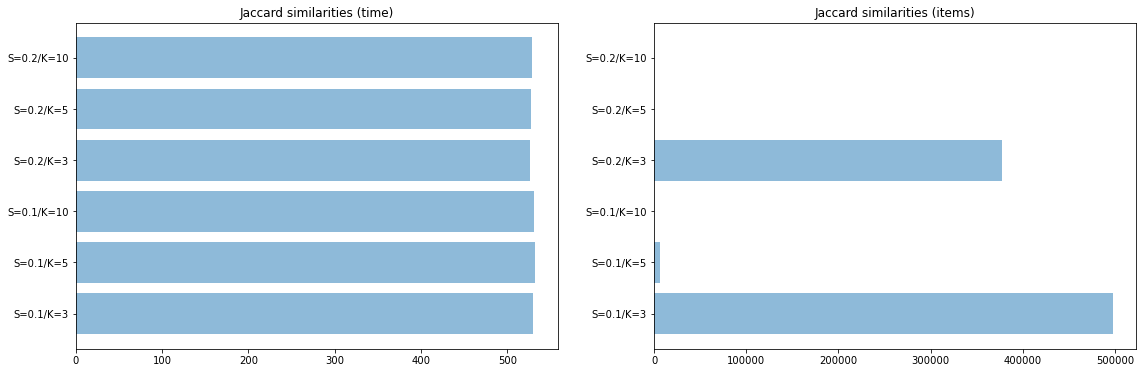

In [16]:
objects = ('S=0.1/K=3', 'S=0.1/K=5', 'S=0.1/K=10', 'S=0.2/K=3', 'S=0.2/K=5', 'S=0.2/K=10')
plot_results('Jaccard similarities', times, num_of_similar_items, objects)

5. MinHashing

In [17]:
# get candidate pairs using MinHashing
bands = 10         # number of bands
rows = 5           # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for s in similarity_threshold:
    
    for k in k_shingles:
        
        signatures = []  # signatures for all files
        
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)
            
        Nfiles = len(signatures)
        
        t = time()
        candidates = []
        for i in range(Nfiles):
            for j in range(i+1, Nfiles):
                Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
                if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                    candidates.append((i,j))
        t1 = time() - t

        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))  
        if(len(candidates) < 11):
            print(candidates)
        print("Took {} seconds\n".format(t1))     
        
        num_of_similar_items.append(len(candidates))
        times.append(t1)        

        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 487955
Took 8.614227533340454 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 158510
Took 8.513476610183716 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of candidates found: 149
Took 8.380528450012207 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of candidates found: 296028
Took 8.536041975021362 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of candidates found: 3055
Took 8.35993480682373 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of candidates found: 1
[(208, 719)]
Took 8.381776571273804 seconds



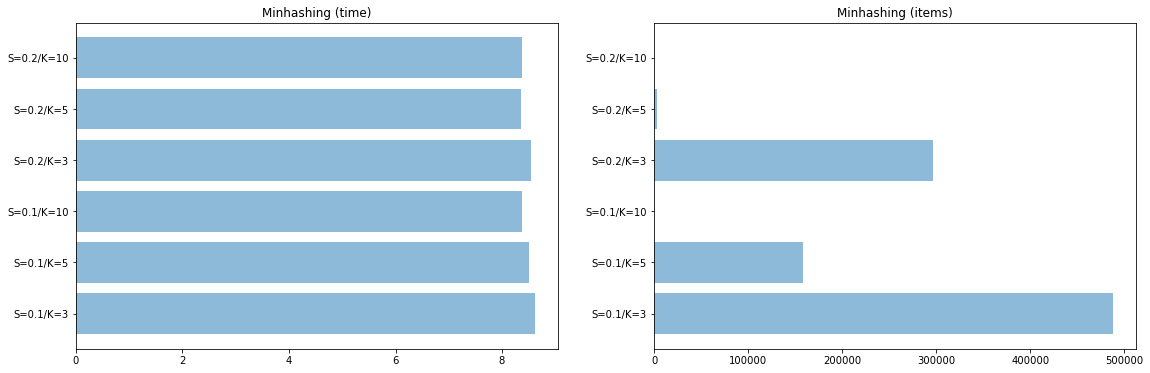

In [18]:
objects = ('S=0.1/K=3', 'S=0.1/K=5', 'S=0.1/K=10', 'S=0.2/K=3', 'S=0.2/K=5', 'S=0.2/K=10')
plot_results('Minhashing', times, num_of_similar_items, objects)

6. Locality Sensitive Hashing (LSH)

In [19]:
# get candidate pairs using Local Sensitive Hashing (LSH) with thresholds 0.1 and 0.2
list = [(100,2),(125,3)]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for (bands,rows) in list:
    nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

    maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
    nextPrime = 4294967311  # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    for k in k_shingles:
        signatures = []  # signatures for all files
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)

        # prepare data for LSH
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

        #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows and the number of bands 
        Nfiles = signatures.shape[1]  # number of different files
        t = time()
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t1 = time() - t
     
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        num_of_similar_items.append(len(candidates))
        times.append(t1)  

K_Shingles: 3
Num of candidates found: 488719
Took 22.8017361164093 seconds

K_Shingles: 5
Num of candidates found: 123520
Took 2.045487403869629 seconds

K_Shingles: 10
Num of candidates found: 3481
Took 0.6786003112792969 seconds

K_Shingles: 3
Num of candidates found: 381492
Took 8.549789905548096 seconds

K_Shingles: 5
Num of candidates found: 21568
Took 1.0979371070861816 seconds

K_Shingles: 10
Num of candidates found: 24
Took 0.7992448806762695 seconds



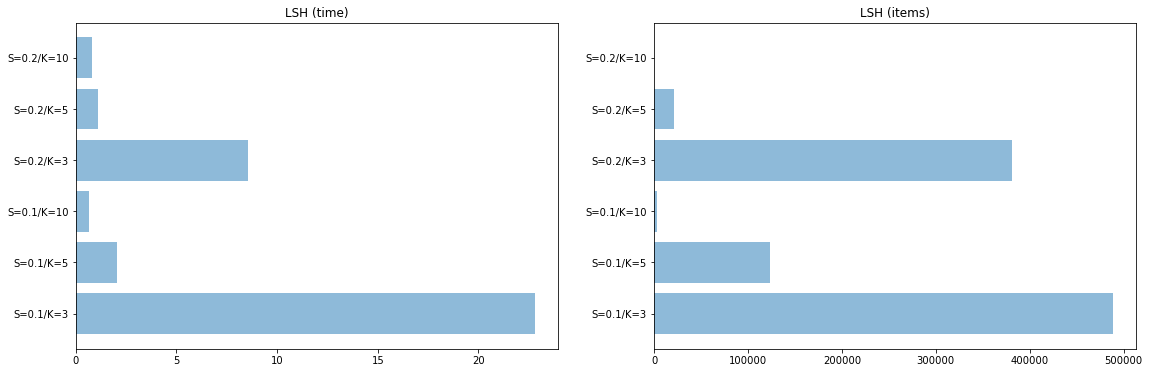

In [20]:
plot_results('LSH', times, num_of_similar_items, objects)

200 0.1
375 0.2
180 0.2554364774645177


Text(0.5, 1.0, 'Similarity threshold = 0.25')

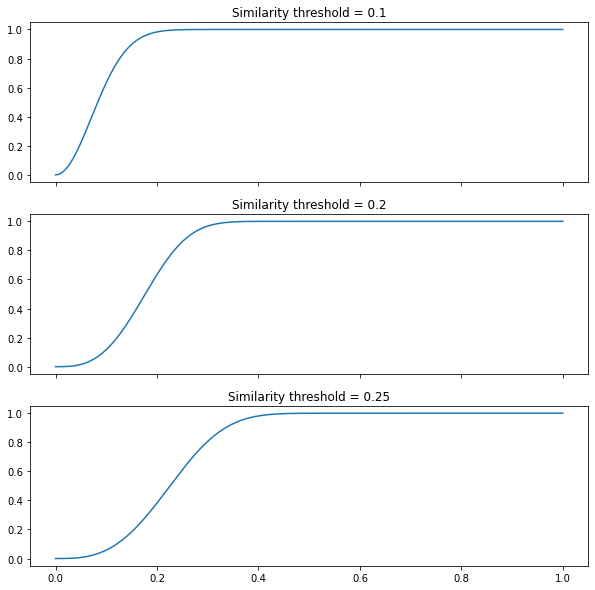

In [21]:
# Plot the selected number of bands and rows to obtain the desired threshold

# s = 0.1
b1 = 100
r1 = 2
print(b1*r1, (1.0/b1)**(1.0/r1))

# s = 0.2
b2 = 125
r2 = 3
print(b2*r2, (1.0/b2)**(1.0/r2))

# s = 0.25
b3 = 60
r3 = 3
print(b3*r3, (1.0/b3)**(1.0/r3))

t = np.linspace(0,1,1000)  # just lots of points between 0 and 1 for plotting
p1 = 1 - np.power((1 - np.power(t, r1)), b1)  # Formula: p = 1 - (1 - t^r)^b 
p2 = 1 - np.power((1 - np.power(t, r2)), b2)  # Formula: p = 1 - (1 - t^r)^b 
p3 = 1 - np.power((1 - np.power(t, r3)), b3)  # Formula: p = 1 - (1 - t^r)^b 

plt.rcParams["figure.figsize"] = (10,10)

fig, axs = plt.subplots(3, sharex=True, sharey=True)
axs[0].plot(t,p1)
axs[0].set_title('Similarity threshold = 0.1')
axs[1].plot(t,p2)
axs[1].set_title('Similarity threshold = 0.2')
axs[2].plot(t,p3)
axs[2].set_title('Similarity threshold = 0.25')

7. Comments

With these exexcutions we have seen that MinHash and LSH techniques provide an estimate of Jaccard Similarity Coefficient with much fewer computations.

LSH performs much faster than the other techniques but also includes more false positives and false negatives.

<hr>

#### 2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

Minhashing

In [22]:
# get candidate pairs using MinHashing
# set global parameters to process the whole dataset
list = [(10,5),(10,10),(20,10)]
similarity_threshold = [0.1, 0.2, 0.25]
k_shingles = [3,5,10]

labels = []
num_of_similar_items = []
times = []   

for (bands,rows) in list:
    nsig = bands*rows           # number of elements in signature, or the number of different random hash functions
    maxShingleID = 2**32-1      # record the maximum shingle ID that we assigned
    nextPrime = 4294967311      # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    for s in similarity_threshold:            
        for k in k_shingles:
            signatures = []  # signatures for all files
        
            for a in abstracts:
                shingles = get_shingles(a, k)
                signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
                signatures.append(signature)
            
            Nfiles = len(signatures)
        
            t = time()
            candidates = []
            for i in range(Nfiles):
                for j in range(i+1, Nfiles):
                    Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
                    if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                        candidates.append((i,j))
            t1 = time() - t

            print('Similarity threshold:', s)        
            print('K_Shingles:', k)
            print('Num of hashing functions:', nsig)        
            print('Num of candidates found:', len(candidates))             
            labels.append('s=' + str(s) + '/' + 'K=' + str(k) + '/H=' + str(nsig))
            print("Took {} seconds\n".format(t1))     

            num_of_similar_items.append(len(candidates))
            times.append(t1)        

Similarity threshold: 0.1
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 488003
Took 8.689929723739624 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of hashing functions: 50
Num of candidates found: 103798
Took 8.536864757537842 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of hashing functions: 50
Num of candidates found: 98
Took 8.444589853286743 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 301300
Took 8.630599975585938 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of hashing functions: 50
Num of candidates found: 1001
Took 8.4491708278656 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of hashing functions: 50
Num of candidates found: 0
Took 8.457028150558472 seconds

Similarity threshold: 0.25
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 130064
Took 8.463310480117798 seconds

Similarity threshold: 0.25
K_Shingles: 5
Num of hashing functions: 50
Num of ca

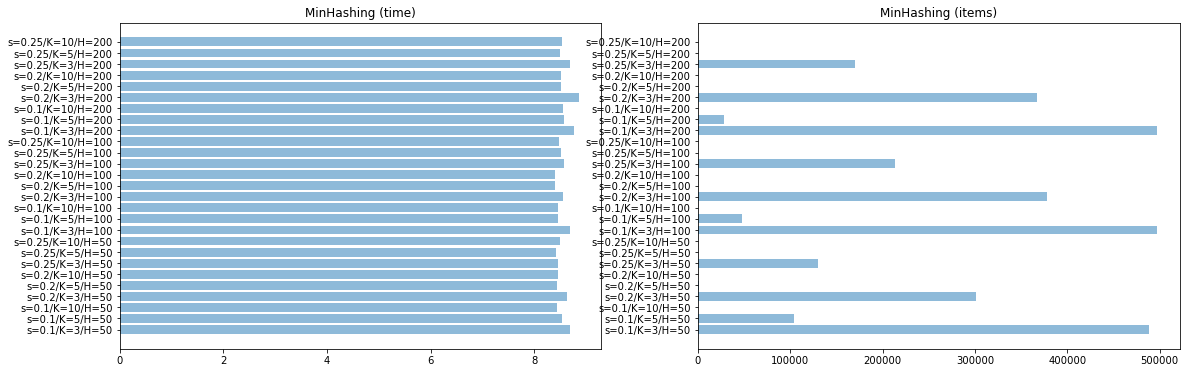

In [23]:
plot_results('MinHashing', times, num_of_similar_items, labels)

Local Sensitive Hashing (LSH)

In [24]:
list = [(100,2),(125,3),(60,3)]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []
labels = []

for (bands,rows) in list:
    nsig = bands*rows           # number of elements in signature, or the number of different random hash functions
    s = (1.0/bands)**(1.0/rows) # calculate the threshold
    maxShingleID = 2**32-1      # record the maximum shingle ID that we assigned
    nextPrime = 4294967311      # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)


    for k in k_shingles:
        signatures = []  # signatures for all files
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)

        # prepare data for LSH
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

        #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows (r) and the number of bands (b)
        Nfiles = signatures.shape[1]  # number of different files
        t = time()
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t1 = time() - t
     
        print('Similarity threshold:', s) 
        print('K_Shingles:', k)  
        print('Num of hashing functions:', nsig)       
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        labels.append('s=' + str("{:0.2f}".format(s)) + '/' + 'K=' + str(k) + '/H=' + str(nsig))
        num_of_similar_items.append(len(candidates))
        times.append(t1)  

Similarity threshold: 0.1
K_Shingles: 3
Num of hashing functions: 200
Num of candidates found: 488871
Took 24.656306982040405 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of hashing functions: 200
Num of candidates found: 149330
Took 2.3857364654541016 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of hashing functions: 200
Num of candidates found: 2879
Took 0.6750049591064453 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of hashing functions: 375
Num of candidates found: 374473
Took 7.853050231933594 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of hashing functions: 375
Num of candidates found: 15188
Took 1.0205109119415283 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of hashing functions: 375
Num of candidates found: 61
Took 0.780228853225708 seconds

Similarity threshold: 0.2554364774645177
K_Shingles: 3
Num of hashing functions: 180
Num of candidates found: 260131
Took 3.945794105529785 seconds

Similarity threshold: 0.2554364774645177
K_Shing

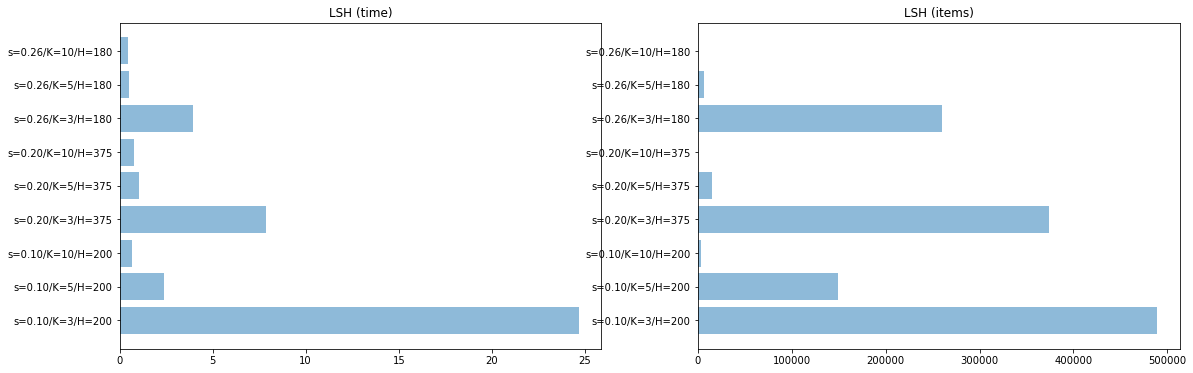

In [25]:
plot_results('LSH', times, num_of_similar_items, labels)

<hr>

#### 3. For MinHashing using 100 hashing functions and s = 0.1 and 0.2, find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each s. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

In [106]:
# Get candidate pairs using MinHashing
bands = 10         # number of bands
rows = 5           # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

pairs_dictionary = {}
signatures = []  
for a in abstracts:
    shingles = get_shingles(a, k=5)
    signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
    signatures.append(signature)

s = 0.2 # similarity threshold
Nabstracts = len(signatures)
t = time()
candidates = []
for i in range(Nabstracts):
    for j in range(i+1, Nabstracts):
        Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
        if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
            candidates.append((i,j, Jsim))            
t2 = time() - t
print("Finding candidates took {} seconds".format(t2))
print("Num of candidates found: {}".format(len(candidates)))   
print("Candidate pairs are:")
print("")

for i,j,js in candidates:
    pairs = [data['ID'][i], data['ID'][j]]
    jd = 1-js

    print(tuple(pairs),jd)
    pairs_dictionary[tuple(pairs)] = jd


Finding candidates took 5.186640977859497 seconds
Num of candidates found: 576
Candidate pairs are:

('du-way-2010-using', 'singla-etal-2020-towards') 0.78
('le-lan-etal-2016-autoapprentissage', 'kolyvakis-etal-2018-deepalignment') 0.78
('le-lan-etal-2016-autoapprentissage', 'ahmadnia-dorr-2019-enhancing') 0.8
('le-lan-etal-2016-autoapprentissage', 'marimon-etal-2012-iula') 0.78
('le-lan-etal-2016-autoapprentissage', 'salaberri-etal-2014-first') 0.8
('le-lan-etal-2016-autoapprentissage', 'rozovskaya-2021-spelling') 0.8
('le-lan-etal-2016-autoapprentissage', 'falis-etal-2019-ontological') 0.8
('le-lan-etal-2016-autoapprentissage', 'schuster-etal-2019-cross-lingual') 0.8
('le-lan-etal-2016-autoapprentissage', 'norman-etal-2019-distantly') 0.74
('le-lan-etal-2016-autoapprentissage', 'amaro-2014-extracting') 0.78
('huber-coltekin-2020-reproduction', 'branco-etal-2012-propbank') 0.8
('mazare-etal-2018-training', 'hsieh-etal-2021-enconter') 0.72
('echizenya-etal-2019-word', 'wong-2010-semant

In [108]:
# list of unique elements
unique = list(set([i[0] for i in [*pairs_dictionary]] + [i[1] for i in [*pairs_dictionary]]))
print(len(unique))

403


In [109]:
print(unique)

['singh-etal-2021-exploring', 'vu-etal-2020-predicting', 'li-specia-2019-comparison', 'jaffe-etal-2020-coreference', 'lin-etal-2021-weight', 'bejan-harabagiu-2008-linguistic', 'shahbazi-etal-2020-relation', 'wang-etal-2020-contextualized', 'sindlerova-etal-2014-resources', 'he-2021-parallel', 'krumbiegel-etal-2020-information', 'kolyvakis-etal-2018-deepalignment', 'yeh-chen-2019-flowdelta', 'bicici-2017-rtm', 'van-niekerk-etal-2021-uncertainty', 'stadelmaier-pado-2019-modeling', 'wang-2019-towards', 'salehi-etal-2017-huntsville', 'leng-etal-2021-fastcorrect-2', 'beltagy-etal-2021-overview', 'mille-etal-2019-teaching', 'wanzare-etal-2017-inducing', 'pedinotti-etal-2021-cat', 'feng-wan-2019-towards', 'singla-etal-2020-towards', 'shreevastava-foltz-2021-detecting', 'tan-bansal-2018-object', 'moreno-2021-repu', 'sweeney-padmanabhan-2017-multi', 'nevezhin-etal-2020-topic', 'dayanik-pado-2020-masking', 'vogt-etal-2021-early', 'reimer-etal-2021-modern', 'sheikh-etal-2016-diachronic', 'ziai-me

In [110]:
def get_idx(fclusters, sub_unique):

    for fkey in list(fclusters):
        comp = set(fclusters[fkey]).isdisjoint(sub_unique)
        
        if comp is False:
            return fkey, False
        else:
            return False, True

        

In [111]:
def get_subset_unique(dtemp, kk):

    c = list(sorted(dtemp.items(), key=lambda x: x[1]))
    sub_ord = [a[0] for a in c[:kk]]
    sub_unique = list(set(sum(sub_ord, ())))

    return sub_unique

In [140]:
fclusters = {}
kk = 5
idx = 1

for unq in unique:
    dtemp = {}

    for j in [*pairs_dictionary]:
        if unq in j:
            dtemp[j] = pairs_dictionary[j]

    sub_unique = get_subset_unique(dtemp, kk)               # sort by distance and select the top kk nearest neighbors 
                                                            # returns a list of unique elements
                
    if idx == 1:
        fclusters['Cluster{}'.format(idx)] = sub_unique     # create the first cluster
        idx = idx + 1                                       # with the first list
    
    fkey, comp = get_idx(fclusters,sub_unique)              # search if abstracts appear in one of the clusters
                                                            # if so, returns True/False and which cluster (fkey)

    if comp:                                                # If true, it's a mew cluster
        fclusters['Cluster{}'.format(idx)] = sub_unique
        idx = idx + 1
    else:                                                   # IF false, there are shared element for fkey
        tmp_vals = fclusters[fkey]                          # so it adds these elements into the cluster
        new_vals = list(set(sub_unique + tmp_vals))         # it creates a unique list
        fclusters[fkey] = new_vals


In [139]:
for key in fclusters.keys():
    print(key)
    print(fclusters[key])
    print('')

Cluster1
['singh-etal-2021-exploring', 'kim-etal-2020-contextual', 'chalamandaris-etal-2006-greek', 'chaudhary-etal-2020-topicbert', 'chen-etal-2016-cyut', 'bestgen-2020-reproducing', 'menacer-etal-2017-enhanced', 'gaddy-klein-2021-improved', 'feijo-moreira-2019-summarizing', 'lanser-etal-2016-crowdsourcing', 'huang-zhang-2021-evaluation', 'gupta-etal-2021-mcl', 'janke-etal-2018-university', 'man-duc-trong-etal-2020-introducing', 'bai-etal-2021-syntax', 'zhang-etal-2021-exploratory-study', 'gorelick-etal-2021-syntax', 'alegria-etal-2008-spelling', 'situ-etal-2021-lifelong', 'rajamanickam-etal-2020-joint', 'lin-etal-2021-weight', 'rumshisky-pustejovsky-2006-inducing', 'huber-coltekin-2020-reproduction', 'arroyo-etal-2020-multi', 'bejan-harabagiu-2008-linguistic', 'wang-etal-2018-alibaba', 'passban-etal-2016-enriching', 'norman-etal-2019-distantly', 'franco-penya-mamani-sanchez-2016-tuning', 'tan-etal-2019-context', 'shahbazi-etal-2020-relation', 'alami-etal-2020-lisac', 'abu-farha-magdy

In [121]:
def same_or_not(a, b):
    return not set(a).isdisjoint(b)

In [122]:
for i in itertools.combinations(fclusters.values(), 2):
    gg = same_or_not(i[0], i[1])
    if gg:
        print("some final clusters seem to have siimilar elements")
        print(i[0], i[1])
        print('\n')

some final clusters seem to have siimilar elements
['singh-etal-2021-exploring', 'kim-etal-2020-contextual', 'chalamandaris-etal-2006-greek', 'chen-etal-2016-cyut', 'chaudhary-etal-2020-topicbert', 'menacer-etal-2017-enhanced', 'bestgen-2020-reproducing', 'feijo-moreira-2019-summarizing', 'gaddy-klein-2021-improved', 'lanser-etal-2016-crowdsourcing', 'huang-zhang-2021-evaluation', 'gupta-etal-2021-mcl', 'janke-etal-2018-university', 'man-duc-trong-etal-2020-introducing', 'zhang-etal-2021-exploratory-study', 'gorelick-etal-2021-syntax', 'alegria-etal-2008-spelling', 'situ-etal-2021-lifelong', 'rajamanickam-etal-2020-joint', 'lin-etal-2021-weight', 'rumshisky-pustejovsky-2006-inducing', 'huber-coltekin-2020-reproduction', 'arroyo-etal-2020-multi', 'bejan-harabagiu-2008-linguistic', 'wang-etal-2018-alibaba', 'norman-etal-2019-distantly', 'franco-penya-mamani-sanchez-2016-tuning', 'alami-etal-2020-lisac', 'passban-etal-2016-enriching', 'tan-etal-2019-context', 'shahbazi-etal-2020-relation'

In [137]:
for abstract in fclusters['Cluster2']:
    result = data.loc[data['ID'] == abstract]    
    print(result['abstract'].values)

["psychologists routinely assess people{'}s emotions and traits such as their personality by collecting their responses to survey questionnaires. such assessments can be costly in terms of both time and money and often lack generalizability as existing data cannot be used to predict responses for new survey questions or participants. in this study we propose a method for predicting a participant{'}s questionnaire response using their social media texts and the text of the survey question they are asked. specifically we use natural language processing (nlp) tools such as bert embeddings to represent both participants (via the text they write) and survey questions as embeddings vectors allowing us to predict responses for out-of-sample participants and questions. our novel approach can be used by researchers to integrate new participants or new questions into psychological studies without the constraint of costly data collection facilitating novel practical applications and furthering th